In [1]:
#Importing the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

import pandas_profiling as pf
import scipy.stats as stats
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [2]:
#importing the dataset
bankloans=pd.read_csv("bankloans.csv")

In [3]:
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [4]:
#creating Data Audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(),x.isnull().sum(), x.sum(), x.mean(), x.median(), x.std(), x.var(), 
                      x.min(), x.quantile(0.01), x.quantile(0.05),x.quantile(0.10),x.quantile(0.25),
                      x.quantile(0.50),x.quantile(0.75),x.quantile(0.90),x.quantile(0.95),
                      x.quantile(0.99),x.max()], 
                     index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [5]:
#creating Data Audit Report for categorical variables
def categorical_var_summary(x):
    Mode=x.values_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
#Missing Value imputation
def missing_imputation(x,stats='mean'):
    if (x.dtypes=='float64')|(x.dtypes=='int64'):
        x=x.fillna(x.mean()) if stats=='mean'  else x.fillna(x.median())
    else:
        x=x.fillna(x.mode())
    return x

In [7]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [8]:
profile_report=pf.ProfileReport(bankloans)
profile_report.to_file("Profile_Report_Bankloans.html")

In [9]:
numeric_var_names=[key for key in dict(bankloans.dtypes)
                   if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes)
                   if dict(bankloans.dtypes)[key] in ['object']]

In [10]:
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [11]:
bankloans_num=bankloans[numeric_var_names]

In [12]:
num_summary=bankloans_num.apply(continuous_var_summary).T

In [13]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [14]:
#Seperating the data for new and existing customers
bankloans_existing=bankloans_num[bankloans_num.default.isnull()==0]
bankloans_new=bankloans_num[bankloans_num.default.isnull()==1]

In [15]:
print(bankloans_existing.shape)
print(bankloans_new.shape)

(700, 9)
(150, 9)


In [16]:
# Handling Outliers
bankloans_existing=bankloans_existing.apply(lambda x: x.clip(lower=x.dropna().quantile(0.01),upper=x.dropna().quantile(0.99)))

In [17]:
# Handling Missings
bankloans_existing=bankloans_existing.apply(lambda x:missing_imputation(x))

In [18]:
#Bi variate Analysis to understand correlation

#correlation matrix
corr_matrix=bankloans_existing.corr()
corr_matrix.to_csv('bankloans_corr.csv')

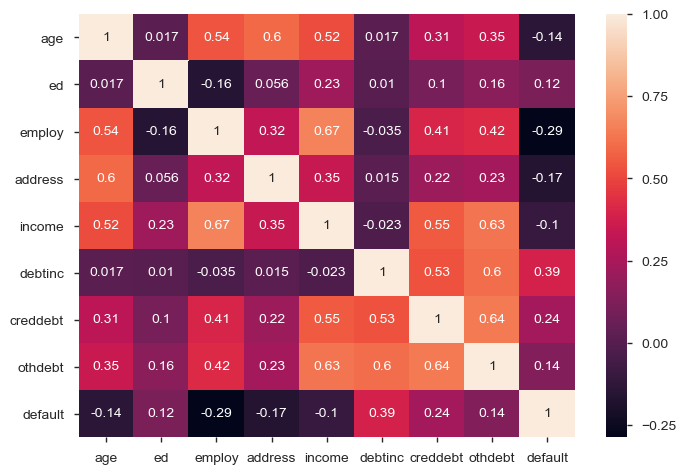

In [19]:
#Visualizing correlation matrix using a heatmap
sns.heatmap(corr_matrix,annot=True)

### Building Logistic Regression Model

In [20]:
train,test=train_test_split(bankloans_existing,test_size=0.3,random_state=42)

In [21]:
train.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [22]:
# 'default~age+ed+employ+address+income+debtinc+creddebtothdebt', 

In [23]:
m1=sm.logit(formula='default~age+employ+address+debtinc+creddebt',data=train).fit()

Optimization terminated successfully.
         Current function value: 0.427051
         Iterations 7


In [24]:
print(m1.summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      484
Method:                           MLE   Df Model:                            5
Date:                Mon, 06 Jul 2020   Pseudo R-squ.:                  0.2721
Time:                        12:49:08   Log-Likelihood:                -209.26
converged:                       True   LL-Null:                       -287.47
                                        LLR p-value:                 5.690e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7615      0.584     -3.018      0.003      -2.905      -0.618
age            0.0392      0.020      1.953      0.051      -0.000       0.078
employ        -0.2541      0.035     -7.306      0.0

In [25]:
m1.predict(train).head()

357    0.585803
649    0.529728
291    0.060701
420    0.599717
177    0.130221
dtype: float64

In [26]:
# Variable Reduction using Somer's D Value

somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ') + str(num_variable), data = bankloans_existing).fit()
    y_score = pd.DataFrame(logreg.predict())
    y_score.columns = ['Score']
    somers_d = 2 * metrics.roc_auc_score(bankloans_existing['default'], y_score) - 1
    temp = pd.DataFrame([num_variable, somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)


Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [27]:
somersd_df

,Variable Name,SomersD
0,address,0.222384
0,age,0.206329
0,creddebt,0.272378
0,debtinc,0.470506
0,ed,0.148302
0,employ,0.409138
0,income,0.200273
0,othdebt,0.173806


In [28]:
#VIF-Variance Inflation Factor
features='+'.join(bankloans_existing.columns.difference(['default']))
features


'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [29]:
a,b=dmatrices('default~'+features,data=bankloans_existing,return_type='dataframe')
vif=pd.DataFrame()
vif["VIF Factor"]=[variance_inflation_factor(b.values,i) for i in range(b.shape[1])]
vif["features"] = b.columns
vif

,VIF Factor,features
0,36.910987,Intercept
1,1.561802,address
2,2.037593,age
3,2.628899,creddebt
4,3.910509,debtinc
5,1.287345,ed
6,2.401544,employ
7,5.121585,income
8,4.562072,othdebt


In [31]:
train['pred_prob'] = m1.predict(train)
train_predict = m1.predict(train)
test_predict = m1.predict(test)
train.head(20)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,pred_prob
357,24.0,2.0,0.0,2.0,15.0,16.100,0.321195,2.093805,1.0,0.585803
649,29.0,2.0,5.0,7.0,28.0,18.700,2.125816,3.110184,0.0,0.529728
291,33.0,4.0,9.0,8.0,32.0,5.500,0.496320,1.263680,0.0,0.060701
420,46.0,1.0,1.0,15.0,21.0,14.800,1.376844,1.731156,1.0,0.599717
177,28.0,2.0,7.0,2.0,34.0,7.000,0.359380,2.020620,0.0,0.130221
456,37.0,4.0,9.0,16.0,177.0,5.900,0.887655,9.555345,0.0,0.047856
444,43.0,4.0,18.0,14.0,190.3,6.500,9.891428,12.958530,1.0,0.637876
83,35.0,4.0,4.0,16.0,29.0,11.000,1.843820,1.346180,0.0,0.296777
453,39.0,1.0,0.0,8.0,39.0,7.900,1.066026,2.014974,0.0,0.573234
354,41.0,3.0,18.0,6.0,71.0,15.700,6.565583,4.581417,1.0,0.454658


In [32]:
#Checking Model Accuracy
metrics.accuracy_score( train['default'],train_predict>0.27)

0.7387755102040816

In [33]:
train_auc = metrics.roc_auc_score(train['default'], train_predict)
test_auc = metrics.roc_auc_score(test['default'], test_predict)
print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.838210632232098
The AUC for the model built on the Test Data is :  0.8885790340981113


In [34]:
print("Response rate (Proportion of 1 vs 0):", train['default'].mean())
print("Average of predicted probalities:", train_predict.mean())

Response rate (Proportion of 1 vs 0): 0.27346938775510204
Average of predicted probalities: 0.27346938775510227


In [35]:
#combine the actual Y values with predicted probabilities
train_predicted_prob = pd.DataFrame(train_predict)
train_predicted_prob.columns = ['prob']
train_pf = pd.concat([train['default'], train_predicted_prob], axis = 1)
train_pf.columns = ['actual', 'prob']
train_pf.head()

,actual,prob
357,1.0,0.585803
649,0.0,0.529728
291,0.0,0.060701
420,1.0,0.599717
177,0.0,0.130221


In [36]:
test_predicted_prob = pd.DataFrame(test_predict)
test_predicted_prob.columns = ['prob']
test_pf = pd.concat([test['default'], test_predicted_prob], axis = 1)
test_pf.columns = ['actual', 'prob']
test_pf.head()

,actual,prob
158,1.0,0.213639
500,0.0,0.462511
396,0.0,0.058998
155,0.0,0.296444
321,1.0,0.300336


In [37]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix( train['default'],train_predict>0.2,[1,0])
cm

array([[119,  15],
       [131, 225]], dtype=int64)

In [38]:
train['default'].value_counts()

0.0    356
1.0    134
Name: default, dtype: int64

Text(0.5, 28.3611111111111, 'Predicted label')

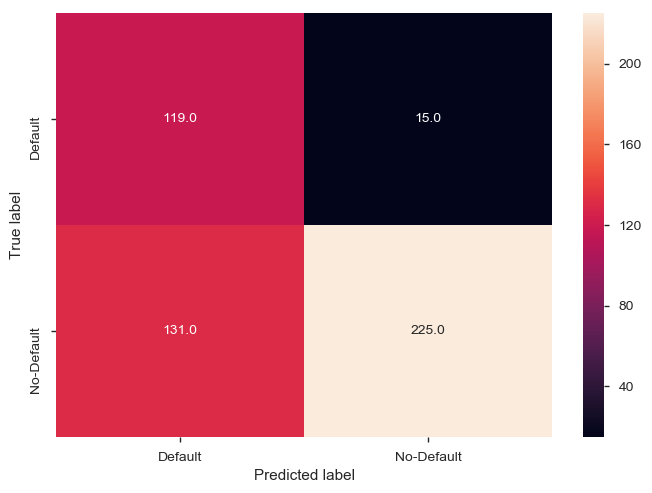

In [39]:
sns.heatmap(cm, annot=True,  fmt='.1f', xticklabels = ["Default", "No-Default"] , yticklabels = ["Default", "No-Default"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [40]:
roc_like_df = pd.DataFrame()
train_temp = train_pf.copy()

for cut_off in np.linspace(0,1,100):
    
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)

roc_like_df['senstivity+specificity'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df

,cutoff,sensitivity,specificity,accuracy,senstivity+specificity
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.010101,1.000000,0.109551,0.353061,1.109551
0,0.020202,1.000000,0.165730,0.393878,1.165730
0,0.030303,0.992537,0.227528,0.436735,1.220065
0,0.040404,0.985075,0.266854,0.463265,1.251929
0,0.050505,0.985075,0.308989,0.493878,1.294063
0,0.060606,0.970149,0.339888,0.512245,1.310037
0,0.070707,0.970149,0.370787,0.534694,1.340936
0,0.080808,0.970149,0.387640,0.546939,1.357790
0,0.090909,0.955224,0.410112,0.559184,1.365336


In [41]:
roc_like_df[roc_like_df['senstivity+specificity'] == roc_like_df['senstivity+specificity'].max()]

,cutoff,sensitivity,specificity,accuracy,senstivity+specificity
0,0.343434,0.738806,0.789326,0.77551,1.528132


In [42]:
test_pf['predicted'] = test_pf['prob'].apply(lambda x: 1 if x > 0.34 else 0)
train_pf['predicted'] = train_pf['prob'].apply(lambda x: 1 if x > 0.34 else 0)

In [43]:
pd.crosstab(train_pf['actual'], train_pf['predicted'])

predicted,0,1
actual,,
0.0,281,75
1.0,35,99


In [44]:
pd.crosstab(test_pf['actual'], test_pf['predicted'])

predicted,0,1
actual,,
0.0,137,24
1.0,13,36


In [45]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_pf.actual, train_pf.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the Train Data is :  0.7755102040816326
The overall accuracy score for the Test Data  is :  0.8238095238095238


### Predicting new customers (Implementation of Model on new data)


In [46]:
# predciting new customers good or bad
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


In [47]:
bankloans_new['prob'] = m1.predict(bankloans_new)
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.012035
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.131542
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.710254
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.096595
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.361547


In [48]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.34 else 0)

In [49]:
bankloans_new.default.value_counts()

0    107
1     43
Name: default, dtype: int64

In [50]:
#We are rejecting applications for 43 customers based on cut-off = 0.34

### Decile Analysis

In [51]:
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutiny
#6th decile onwards - low risk customers - accept the application

In [52]:
train_pf['Deciles'] = pd.qcut(train_pf['prob'], 10, labels = False)
test_pf['Deciles'] = pd.qcut(test_pf['prob'], 10, labels = False)

In [53]:
no_1s = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).sum().sort_index(ascending=False)['actual']
no_total = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).count().sort_index(ascending=False)['actual']
max_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).max().sort_index(ascending=False)['prob']
min_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).min().sort_index(ascending=False)['prob']

In [54]:
Decile_analysis_train = pd.concat([ min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)
Decile_analysis_train.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [55]:
Decile_analysis_train.to_csv('Decile_analysis_bankloans_train.csv')
Decile_analysis_train

,Min_prob,Max_prob,#1,#0,Total
Deciles,,,,,
9,0.629780,0.986816,37.0,12.0,49
8,0.492289,0.625658,29.0,20.0,49
7,0.396660,0.491821,18.0,31.0,49
6,0.289372,0.396070,19.0,30.0,49
5,0.215034,0.288422,15.0,34.0,49
4,0.144435,0.211515,6.0,43.0,49
3,0.084038,0.143758,5.0,44.0,49
2,0.040619,0.083720,3.0,46.0,49
1,0.013535,0.040588,2.0,47.0,49


In [56]:
# Decile analysis for test data
no_1s = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).min().sort_index(ascending=False)['prob']

In [57]:
Decile_analysis_test = pd.concat([min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)
Decile_analysis_test.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [58]:
Decile_analysis_test.to_csv('Decile_analysis_bankloans_test.csv')
Decile_analysis_test

,Min_prob,Max_prob,#1,#0,Total
Deciles,,,,,
9,0.677376,0.972221,19.0,2.0,21
8,0.491667,0.674228,12.0,9.0,21
7,0.320771,0.481541,5.0,16.0,21
6,0.254996,0.312851,5.0,16.0,21
5,0.168005,0.241181,4.0,17.0,21
4,0.117243,0.166776,1.0,20.0,21
3,0.066399,0.116729,2.0,19.0,21
2,0.040592,0.065938,1.0,20.0,21
1,0.017485,0.037297,0.0,21.0,21
